In [ ]:
import re
from nltk import word_tokenize
import string
import  gensim.models as md
from gensim.models.phrases import Phrases, Phraser
import numpy

# Text Cleaning

In [17]:
#Creating the function for preprocessing the text file, the functions does the following:
#Removing the URLs in the file
#Removing blank lines
#Converting the letters that were not read properly due to encoding, to be viewed properly
#Removing stopwords from the text
#Removing the punctuations form the text

def preProcessor(textFile):
    print('Starting pre-processing of the corpus..')
    print('Start: Word Tokenizing')

    textFilev1 = []
    textFilev1 = [word_tokenize(sent) for sent in textFile]

    print('Stop: Word Tokenizing')
    print('Start: ASCII encoding for special characters')

    textFilev2 = []
    for sent in textFilev1:
        new_sent = []
        for word in sent:
            new_word = word.encode('ascii', 'ignore').decode('utf-8')
            if new_word != '':
                new_sent.append(new_word)
        textFilev2.append(new_sent)

    print('Stop: ASCII encoding for special characters')
    print('Start: Stopwords Removal')

    stopwordsFile = open('/Users/song/Documents/Insight/Project/Data/stopwords.txt')
    stopwordsFile.seek(0)
    stopwordsV1 = stopwordsFile.readlines()
    stopwordsV2 = []
    for sent in stopwordsV1:
        sent.replace('\n', '')
        new_word = sent[0:len(sent) - 1]
        stopwordsV2.append(new_word.lower())

    textFilev1 = []
    for sent in textFilev2:
        new_sent = []
        for word in sent:
            if word.lower() not in stopwordsV2:
                new_sent.append(word.lower())
        textFilev1.append(new_sent)

    print('Stop: Stopwords Removal')
    print('Start: Punctuation Removal')

    textFilev2 = []
    for sent in textFilev1:
        new_sent = []
        for word in sent:
            if word not in string.punctuation:
                new_sent.append(word)
        textFilev2.append(new_sent)

    print('Stop: Punctuation Removal')
    print('Start: Phrase Detection')

    textFilev1 = []
    common_terms = ["of", "with", "without", "and", "or", "the", "a", "so", "and"]
    phraseTrainer = Phrases(textFilev2, delimiter=b' ', common_terms=common_terms)
    phraser = Phraser(phraseTrainer)
    for article in textFilev2:
        textFilev1.append((phraser[article]))

    print('Stop: Phrase Detection')

    return textFilev1

In [18]:
import pandas as pd

#Reading the news articles file
nyTimesFile = open('/Users/song/Documents/Insight/Project/Data/nytimes_news_articles.txt', encoding='latin-1')
nyTimesFile.seek(0)
nyTimesV1 = nyTimesFile.readlines()
nyTimesTemp = []
nyTimesURL = []

for i in range(0, len(nyTimesV1)-1):
    if re.findall('URL', nyTimesV1[i]) == []:
        sent = sent + nyTimesV1[i]
        if (re.findall('URL', nyTimesV1[i+1]) != []) and (i+1 < len(nyTimesV1)):
            nyTimesTemp.append(sent.strip())
    else:
        sent = ''
        nyTimesURL.append(nyTimesV1[i])

for i in range(0, len(nyTimesTemp)):
    nyTimesTemp[i] = nyTimesTemp[i]+'articleID'+str(i)

nytimes = preProcessor(nyTimesTemp)

Starting pre-processing of the corpus..
Start: Word Tokenizing
Stop: Word Tokenizing
Start: ASCII encoding for special characters
Stop: ASCII encoding for special characters
Start: Stopwords Removal
Stop: Stopwords Removal
Start: Punctuation Removal
Stop: Punctuation Removal
Start: Phrase Detection
Stop: Phrase Detection


# LDA Using BOW

In [5]:
import gensim

In [7]:
# Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set, dictionary is id2word
dictionary = gensim.corpora.Dictionary(nytimes)

In [8]:
# filter out some tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [9]:
#For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’
bow_corpus = [dictionary.doc2bow(doc) for doc in nytimes]

In [14]:
# Running LDA using bag of words
lda_model = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=10, id2word=dictionary,eval_every=10,passes=10,iterations=5000,
random_state=numpy.random.RandomState(15))

In [15]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"company" + 0.007*"companies" + 0.005*"business" + 0.004*"million" + 0.004*"market" + 0.004*"united" + 0.004*"money" + 0.003*"investors" + 0.003*"pay" + 0.003*"deal"
Topic: 1 
Words: 0.022*"trump" + 0.010*"clinton" + 0.009*"campaign" + 0.006*"president" + 0.006*"political" + 0.006*"obama" + 0.006*"party" + 0.006*"vote" + 0.005*"voters" + 0.005*"trumps"
Topic: 2 
Words: 0.005*"law" + 0.005*"police" + 0.005*"people" + 0.004*"court" + 0.004*"students" + 0.004*"officials" + 0.004*"school" + 0.003*"city" + 0.003*"including" + 0.003*"lawyer"
Topic: 3 
Words: 0.006*"city" + 0.005*"building" + 0.005*"art" + 0.005*"street" + 0.005*"york" + 0.005*"home" + 0.004*"house" + 0.004*"space" + 0.003*"food" + 0.003*"museum"
Topic: 4 
Words: 0.005*"music" + 0.005*"film" + 0.004*"women" + 0.004*"life" + 0.004*"people" + 0.004*"love" + 0.004*"york" + 0.004*"prince" + 0.003*"mother" + 0.003*"play"
Topic: 5 
Words: 0.010*"people" + 0.003*"dr." + 0.003*"found" + 0.003*"day" + 0.002*"cal

In [16]:
# compute coherence score:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=nytimes, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5665156593303704


In [19]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.007995 -0.096376       1        1  17.379612
2      0.125751  0.012814       2        1  14.242615
0      0.090551 -0.012186       3        1  12.568131
3     -0.046656 -0.240653       4        1  10.645781
4     -0.069533 -0.121479       5        1  10.382177
6     -0.173053  0.036967       6        1   9.854397
7      0.129844  0.029227       7        1   9.049121
1      0.084964  0.067326       8        1   9.032873
8     -0.273828  0.157719       9        1   4.101148
9      0.123966  0.166641      10        1   2.744153, topic_info=      Category         Freq           Term        Total  loglift  logprob
term                                                                     
2600   Default  4930.000000          trump  4930.000000  30.0000  30.0000
544    Default  4778.000000        company  4778.000000  29.0000  29.0000
58     Default  2915.000000           game  2915.000000  28.0000  28.0000
130    Default  2825.000000         season  2825.000000  27.0000  27.0000
2519   Default  2183.000000        clinton  2183.000000  26.0000  26.0000
2244   Default  2480.000000       campaign  2480.000000  25.0000  25.0000
156    Default  3265.000000           team  3265.000000  24.0000  24.0000
420    Default  3602.000000     government  3602.000000  23.0000  23.0000
999    Default  2278.000000      companies  2278.000000  22.0000  22.0000
895    Default  4624.000000         united  4624.000000  21.0000  21.0000
110    Default  2179.000000        players  2179.000000  20.0000  20.0000
1379   Default  3057.000000      president  3057.000000  19.0000  19.0000
1180   Default  1859.000000            law  1859.000000  18.0000  18.0000
211    Default  3731.000000           city  3731.000000  17.0000  17.0000
7772   Default  1543.000000          obama  1543.000000  16.0000  16.0000
2894   Default  1440.000000          music  1440.000000  15.0000  15.0000
1374   Default  2621.000000           play  2621.000000  14.0000  14.0000
295    Default  2284.000000         police  2284.000000  13.0000  13.0000
59     Default  1551.000000          games  1551.000000  12.0000  12.0000
297    Default  2144.000000      political  2144.000000  11.0000  11.0000
1895   Default  2770.000000      officials  2770.000000  10.0000  10.0000
3215   Default   913.000000        yankees   913.000000   9.0000   9.0000
1614   Default  1406.000000           vote  1406.000000   8.0000   8.0000
1616   Default  1191.000000         voters  1191.000000   7.0000   7.0000
1323   Default  1279.000000           film  1279.000000   6.0000   6.0000
2823   Default  1584.000000            art  1584.000000   5.0000   5.0000
901    Default  1889.000000            win  1889.000000   4.0000   4.0000
1006   Default  2742.000000        country  2742.000000   3.0000   3.0000
1310   Default  1957.000000          court  1957.000000   2.0000   2.0000
467    Default  2000.000000          party  2000.000000   1.0000   1.0000
...        ...          ...            ...          ...      ...      ...
6201   Topic10   277.633759           cuba   287.693085   3.5601  -5.5222
710    Topic10   346.760132       athletes   385.935120   3.4887  -5.2998
19023  Topic10   116.529602       carnival   121.467239   3.5542  -6.3903
20181  Topic10   112.847588          chess   117.672356   3.5538  -6.4224
4681   Topic10   205.941193      brazilian   224.930176   3.5075  -5.8209
1885   Topic10   158.542587         moscow   172.907379   3.5090  -6.0824
12486  Topic10   153.611618        russias   168.779404   3.5015  -6.1140
7930   Topic10   354.216461         brazil   447.356323   3.3623  -5.2785
829    Topic10   221.078674       olympics   262.182129   3.4252  -5.7499
6213   Topic10   199.905670           espn   233.415421   3.4407  -5.8506
1952   Topic10   414.643585        russian   570.777344   3.2761  -5.1210
858    Topic10   544.583557         russia   808.4573

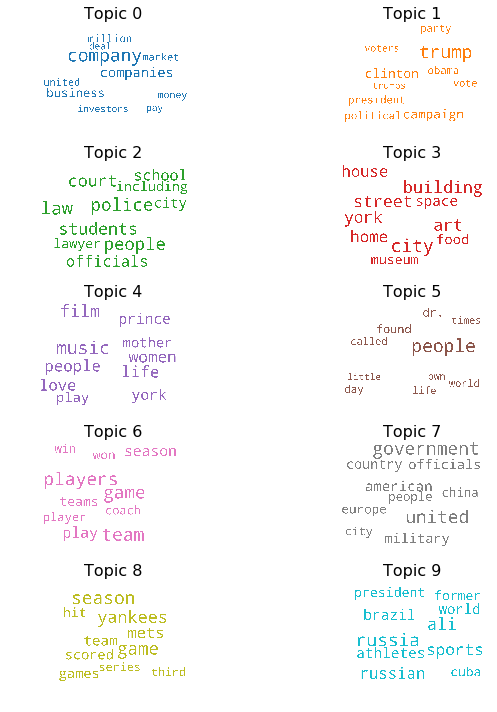

In [22]:
#  Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [23]:
# compute coherence score:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=nytimes, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4106134648541878


# LDA Using TF-DIF

In [12]:
# TF-DIF
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [15]:
# Running LDA using TF-IDF 
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [17]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.001*"mr." + 0.001*"game" + 0.001*"city" + 0.001*"company" + 0.001*"beyonc" + 0.001*"prince" + 0.001*"scored" + 0.001*"album" + 0.001*"season" + 0.001*"lead"
Topic: 1 Word: 0.001*"company" + 0.001*"prince" + 0.001*"mr." + 0.001*"mr. trump" + 0.001*"ms." + 0.001*"people" + 0.001*"theranos" + 0.001*"companies" + 0.001*"government" + 0.001*"building"
Topic: 2 Word: 0.001*"mr." + 0.001*"scored" + 0.001*"flyers" + 0.001*"government" + 0.001*"players" + 0.001*"game" + 0.001*"city" + 0.001*"goal" + 0.001*"games" + 0.001*"women"
Topic: 3 Word: 0.001*"mr." + 0.001*"united" + 0.001*"mr. obama" + 0.001*"volkswagen" + 0.001*"company" + 0.001*"mr. trump" + 0.001*"prince" + 0.001*"european union" + 0.001*"police" + 0.001*"europe"
Topic: 4 Word: 0.002*"yankees" + 0.001*"mr." + 0.001*"game" + 0.001*"season" + 0.001*"mr. trump" + 0.001*"leicester" + 0.001*"mets" + 0.001*"players" + 0.001*"york" + 0.001*"girardi"
Topic: 5 Word: 0.001*"mr." + 0.001*"mr. trump" + 0.001*"ms." + 0.001*"film"

In [25]:
coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=nytimes, dictionary=dictionary, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda_tfidf)


Coherence Score:  0.25198440655122


In [18]:
# performance check
nytimes[4310]

['nathan eovaldi',
 'r. a.',
 'dickey',
 'share',
 'common',
 'pitching',
 'style',
 'musical',
 'proclivities',
 'portly',
 'rapper',
 'fat',
 'joe',
 'aging',
 'gray-haired',
 'rocker',
 'jon',
 'bon jovi',
 'attendance',
 'tuesday nights',
 'game',
 'yankees',
 'toronto blue',
 'jays',
 'eovaldis',
 'flair',
 'six-plus',
 'innings',
 'shutout',
 'ball',
 'won',
 'dickeys',
 'fluttering',
 'artistry',
 'yankees',
 'defeated',
 'blue jays',
 '6-0',
 'yankee stadium',
 'victory',
 'moved',
 'yankees',
 '22-22',
 'time',
 'reached',
 '.500',
 'april 14',
 'extended',
 'winning streak',
 'six games',
 'carlos beltran',
 'collected',
 'r.b.i',
 'dickey',
 'former',
 'mets',
 'teammate',
 'including',
 'booming',
 'leadoff',
 'home run',
 'deck',
 'field',
 'fourth',
 'started',
 'season',
 'beltran',
 'reaching',
 '.500.',
 'theres doubt',
 'played',
 'horrible',
 'month.',
 'key',
 'yankees',
 'turnaround',
 'eovaldi',
 '5-2',
 'improved',
 '5-0',
 'six starts',
 'wednesday',
 'shut',
 '

In [19]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5476999282836914	 
Topic: 0.008*"game" + 0.007*"team" + 0.006*"players" + 0.005*"season" + 0.005*"games" + 0.004*"play" + 0.004*"teams" + 0.003*"series" + 0.003*"win" + 0.003*"scored"

Score: 0.44873687624931335	 
Topic: 0.004*"yankees" + 0.004*"people" + 0.003*"google" + 0.002*"day" + 0.002*"mr." + 0.002*"week" + 0.002*"company" + 0.002*"including" + 0.002*"united" + 0.002*"game"


In [20]:

for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5852786898612976	 
Topic: 0.002*"yankees" + 0.001*"mr." + 0.001*"game" + 0.001*"season" + 0.001*"mr. trump" + 0.001*"leicester" + 0.001*"mets" + 0.001*"players" + 0.001*"york" + 0.001*"girardi"

Score: 0.25725269317626953	 
Topic: 0.001*"mr." + 0.001*"scored" + 0.001*"flyers" + 0.001*"government" + 0.001*"players" + 0.001*"game" + 0.001*"city" + 0.001*"goal" + 0.001*"games" + 0.001*"women"

Score: 0.08015956729650497	 
Topic: 0.002*"mr. trump" + 0.001*"mr." + 0.001*"curry" + 0.001*"google" + 0.001*"mrs. clinton" + 0.001*"warriors" + 0.001*"ms." + 0.001*"police" + 0.001*"company" + 0.001*"film"

Score: 0.04056834802031517	 
Topic: 0.001*"mr." + 0.001*"dr." + 0.001*"mr. trump" + 0.001*"people" + 0.001*"mrs. clinton" + 0.001*"ms." + 0.001*"company" + 0.001*"mr. sanders" + 0.001*"york" + 0.001*"city"

Score: 0.034484654664993286	 
Topic: 0.001*"mr." + 0.001*"united" + 0.001*"mr. obama" + 0.001*"volkswagen" + 0.001*"company" + 0.001*"mr. trump" + 0.001*"prince" + 0.001*"european u

## Bert

In [6]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling
import tensorflow as tf
import numpy as np
import itertools

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
BERT_VOCAB = '~/Documents/Insight/Project/bert/uncased_L-12_H-768_A-12/vocab.txt'
BERT_INIT_CHKPNT = '~/Documents/Insight/Project/bert/uncased_L-12_H-768_A-12/bert_model.ckpt'
BERT_CONFIG = '~/Documents/Insight/Project/bert/uncased_L-12_H-768_A-12/bert_config.json'

# word2vec

In [20]:
len(nytimes)

8893

In [22]:
maxlen = 0
for i in range(len(nytimes)):
    maxlen = max(maxlen,len(nytimes[i]))

In [23]:
maxlen

4136

In [24]:
from gensim.models import KeyedVectors

In [25]:
EMBEDDING_FILE = '~/Documents/Insight/Project/word2vec/GoogleNews-vectors-negative300.bin.gz'
vocabulary = {}
inverse_vocabulary = ['<unk>']
w2v_model = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

In [33]:
len(w2v_model.word_vec('you'))

300

In [34]:
nytimes[0]

['washington',
 'stellar',
 'pitching',
 'kept',
 'mets',
 'afloat',
 'half',
 'season',
 'despite',
 'offensive',
 'woes',
 'produce',
 'encore',
 'pennant-winning',
 'season',
 'lineup',
 'floundering',
 'pitching',
 'nicked',
 'bruised',
 'stretched',
 'thin',
 'ride',
 'pitching',
 'manager terry',
 'collins',
 'wednesdays game',
 'riding',
 'weve',
 'pitching',
 'anything.',
 'wednesdays',
 '4-2',
 'loss',
 'washington nationals',
 'cruel',
 'already-limping',
 'mets',
 'pitching',
 'steven',
 'matzs',
 'spot',
 'starter',
 'logan verrett',
 'allowed runs',
 'five innings',
 'deficit',
 'mets lineup',
 'overcome',
 'max scherzer',
 'nationals',
 'starter',
 'giving',
 'ourselves',
 'chances',
 'collins',
 'adding',
 'cant',
 'pitchers',
 'work.',
 'mets',
 'score',
 'ninth inning',
 'last-gasp',
 'two-run homer',
 'james loney',
 'nationals',
 'reliever',
 'shawn',
 'kelley',
 'snapped',
 'streak',
 '23',
 'scoreless innings',
 'team',
 'mets',
 'swept',
 'three-game series',
 'si

In [39]:
# Replace articles with list of word indices, include stopwords if they have embeddings
nytimesIndex = []
for article in nytimes:
    q2n = []
    for word in article:
        if word not in w2v_model.vocab:
            continue
        if word not in vocabulary:
            vocabulary[word] = len(inverse_vocabulary)
            q2n.append(len(inverse_vocabulary))
            inverse_vocabulary.append(word)
        else:
            q2n.append(vocabulary[word])
    nytimesIndex.append(q2n)            

In [40]:
len(nytimesIndex)

8893

In [45]:

embedding_dim = 300
embeddings = np.random.randn(100,embedding_dim)
embeddings[0]=0

for i in range(100):
     
    embeddings[i] = w2v_model.word_vec(inverse_vocabulary[nytimesIndex[0][i]])


In [47]:
embeddings.shape

(100, 300)

In [48]:
import numpy as np

In [55]:
embedding_dim = 300
nytimesEmbedding = np.random.rand(8893,300)
for i, article in enumerate(nytimesIndex):
    embedding = np.random.randn(len(article),embedding_dim)
    for i in range(len(article)):
        embedding[i] = w2v_model.word_vec(inverse_vocabulary[article[i]])
    embedding = np.mean(np.transpose(embedding), axis = 1)
    nytimesEmbedding[i] = embedding

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [56]:
nytimesEmbedding.shape

(8893, 300)

In [60]:
nytimesEmbedding[3]

array([ 1.66137695e-01, -2.75268555e-02,  7.54699707e-02,  2.20458984e-01,
        3.02734375e-02, -1.73156738e-01, -4.09545898e-02,  3.84521484e-03,
        9.76562500e-03,  2.40478516e-01, -1.06811523e-03, -6.78710938e-02,
        6.22558594e-02,  1.24816895e-01, -1.52954102e-01,  2.45666504e-02,
        9.50317383e-02,  8.86535645e-03,  6.46972656e-03, -6.93969727e-02,
        7.58056641e-02,  2.18017578e-01,  3.21044922e-02,  1.01318359e-01,
        4.91333008e-02, -4.64057922e-02,  2.56347656e-03,  1.29882812e-01,
        1.35421753e-01, -5.30204773e-02, -7.37304688e-02,  1.36596680e-01,
        1.96777344e-01,  1.12060547e-01,  2.91137695e-02,  1.25488281e-01,
        1.89208984e-01, -1.08825684e-01,  9.15527344e-05, -2.28881836e-02,
        1.18347168e-01, -2.05322266e-01,  9.19189453e-02,  1.21459961e-01,
       -3.13720703e-02,  1.23291016e-02,  3.14331055e-02,  3.19213867e-02,
        2.88574219e-01,  4.88281250e-03, -2.78076172e-01,  2.03247070e-01,
        5.37109375e-03, -

# tsne visualization of Embedding

In [99]:
from sklearn.manifold import TSNE
import matplotlib. pyplot as plt

In [95]:
nytimesEmbedding = nytimesEmbedding.tolist()

TypeError: zip argument #1 must support iteration

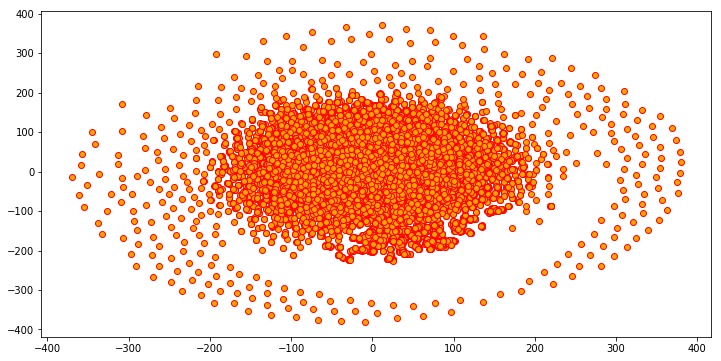

In [100]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(nytimesEmbedding)
labels = nytimesEmbedding.index
        
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

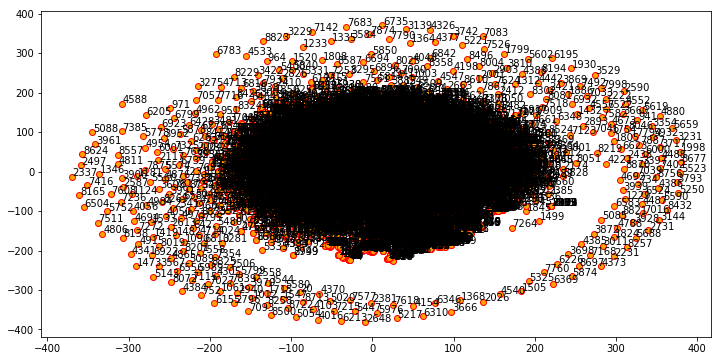

In [105]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(nytimesEmbedding)
labels = [i for i in range(len(nytimesEmbedding))]
        
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

# kmean clustering

In [27]:
#https://github.com/gaetangate/word2vec-cluster/blob/master/word2vec_cluster.py
word_vectors = w2v_model.wv.syn0

n_words = word_vectors.shape[0]
vec_size = word_vectors.shape[1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [62]:
type(nytimesEmbedding)

numpy.ndarray

In [84]:
#clean the dataset of nan, Inf
nytimesEmbedding = np.nan_to_num(nytimesEmbedding)

In [86]:
np.all(np.isfinite(nytimesEmbedding))

np.any(np.isnan(nytimesEmbedding))

True

In [ ]:
#clean the dataset of nan, Inf
import pandas as pd
df = pd.dataFrame()
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [87]:
# https://stackoverflow.com/questions/31323499/sklearn-error-valueerror-input-contains-nan-infinity-or-a-value-too-large-for
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_jobs=-1, random_state=0)
kmeans.fit_predict(nytimesEmbedding)

In [ ]:
kmeans.

In [93]:
ls = [[1],[2],[3]]

In [103]:
ls.index

<function list.index>

# EMLO

In [109]:
import tensorflow_hub as hub

In [110]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

Instructions for updating:
Colocations handled automatically by placer.


W0120 22:34:39.917854 140735766508480 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# split data  into batche
list_nytimesEm

# LDA2VEC

In [108]:
import lda2vec

AttributeError: module 'lda2vec' has no attribute 'dirichlet_likelihood'